In [74]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_error, mean_squared_error, silhouette_score
from sklearn import preprocessing
from sklearn.cluster import KMeans

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pandas.plotting import autocorrelation_plot

import warnings
warnings.filterwarnings('ignore')

In [75]:
# %pip install "numpy<1.24"

In [76]:
df_regresi = pd.read_csv('./case_study/dataset_merge.csv')

df_regresi.sample(5)

,TransactionID,CustomerID,Date,ProductID,Price,Qty,TotalAmount,StoreID,Age,Gender,Marital Status,Income,Product Name,StoreName,GroupStore,Type,Latitude,Longitude
3484,TR22980,396,2022-02-27,P2,3200,6,19200,2,36,1,Married,9.18,Ginger Candy,Prima Kelapa Dua,Prima,Modern Trade,-6.914864,107.608238
3692,TR80747,177,2022-10-01,P5,4200,5,21000,8,33,1,Married,8.06,Thai Tea,Sinar Harapan,Harapan Baru,General Trade,5.548290,95.323753
4784,TR51709,40,2022-08-21,P5,4200,3,12600,4,19,0,Single,3.48,Thai Tea,Gita Ginara,Gita,General Trade,-6.966667,110.416664
1984,TR14209,109,2022-07-01,P7,9400,3,28200,5,35,1,Married,10.04,Coffee Candy,Bonafid,Gita,General Trade,-7.250445,112.768845
2802,TR36913,267,2022-12-10,P2,3200,4,12800,3,22,0,Single,0.00,Ginger Candy,Prima Kota,Prima,Modern Trade,-7.797068,110.370529


In [77]:
df_regresi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TransactionID   5020 non-null   object 
 1   CustomerID      5020 non-null   int64  
 2   Date            5020 non-null   object 
 3   ProductID       5020 non-null   object 
 4   Price           5020 non-null   int64  
 5   Qty             5020 non-null   int64  
 6   TotalAmount     5020 non-null   int64  
 7   StoreID         5020 non-null   int64  
 8   Age             5020 non-null   int64  
 9   Gender          5020 non-null   int64  
 10  Marital Status  4976 non-null   object 
 11  Income          5020 non-null   float64
 12  Product Name    5020 non-null   object 
 13  StoreName       5020 non-null   object 
 14  GroupStore      5020 non-null   object 
 15  Type            5020 non-null   object 
 16  Latitude        5020 non-null   float64
 17  Longitude       5020 non-null   f

In [78]:
df_regresi['Date'] = pd.to_datetime(df_regresi['Date'], format="%Y-%m-%d")

In [79]:
df_regresi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5020 entries, 0 to 5019
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   TransactionID   5020 non-null   object        
 1   CustomerID      5020 non-null   int64         
 2   Date            5020 non-null   datetime64[ns]
 3   ProductID       5020 non-null   object        
 4   Price           5020 non-null   int64         
 5   Qty             5020 non-null   int64         
 6   TotalAmount     5020 non-null   int64         
 7   StoreID         5020 non-null   int64         
 8   Age             5020 non-null   int64         
 9   Gender          5020 non-null   int64         
 10  Marital Status  4976 non-null   object        
 11  Income          5020 non-null   float64       
 12  Product Name    5020 non-null   object        
 13  StoreName       5020 non-null   object        
 14  GroupStore      5020 non-null   object        
 15  Type

In [80]:
df_regresi = df_regresi.groupby(['Date']).agg({
    'Qty': 'sum'
}).reset_index()

df_regresi

,Date,Qty
0,2022-01-01,49
1,2022-01-02,59
2,2022-01-03,63
3,2022-01-04,45
4,2022-01-05,30
...,...,...
360,2022-12-27,70
361,2022-12-28,68
362,2022-12-29,42
363,2022-12-30,44


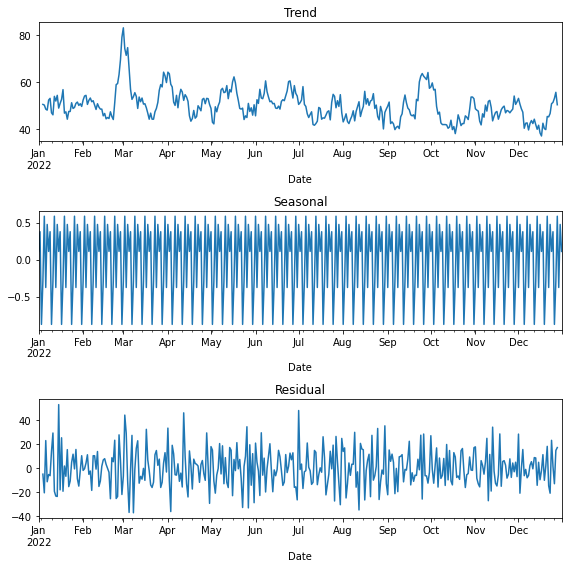

In [81]:
decomposed = seasonal_decompose(df_regresi.set_index('Date'))

plt.figure(figsize=(8, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonal')

plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residual')

plt.tight_layout()

In [82]:
cut_off = round(df_regresi.shape[0] * 0.9)
df_train = df_regresi[:cut_off]
df_test = df_regresi[cut_off:].reset_index(drop=True)

df_train.shape, df_test.shape


((328, 2), (37, 2))

<AxesSubplot:xlabel='Date', ylabel='Qty'>

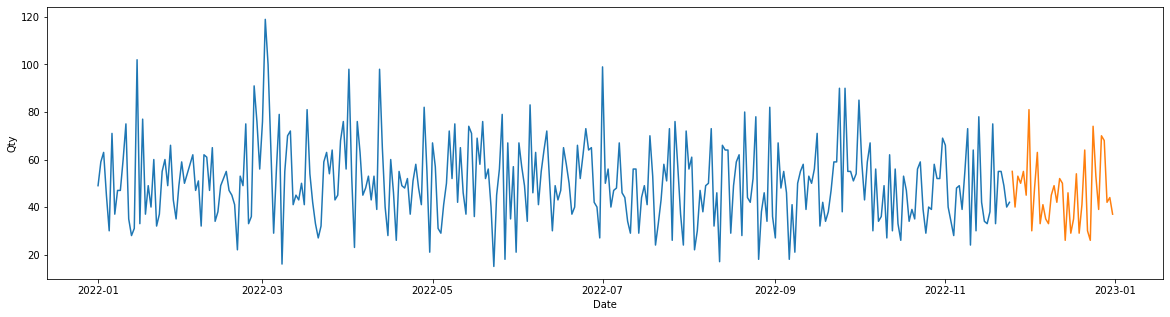

In [83]:
plt.figure(figsize=(20,5))
sns.lineplot(data=df_train, x=df_train['Date'], y=df_train['Qty'])
sns.lineplot(data=df_test, x=df_test['Date'], y=df_test['Qty'])

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

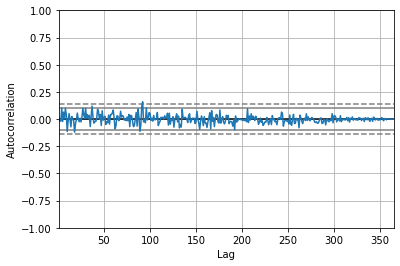

In [84]:
autocorrelation_plot(df_regresi['Qty'])

EVALUATION MACHINE LEARNING MODEL

In [85]:
# Calculate rmse 
def calRmse(y_actual, y_pred):
    print(f'RMSE value: {mean_squared_error(y_actual, y_pred) * 0.5}')


# Calculate MAE 
def calMae(y_actual, y_pred):
    print(f'MAE value: {mean_absolute_error(y_actual, y_pred)}')

def eval(y_actual, y_pred):
    calRmse(y_actual, y_pred)
    calMae(y_actual, y_pred)

RMSE value: 97.70303219213493
MAE value: 10.669559130367317


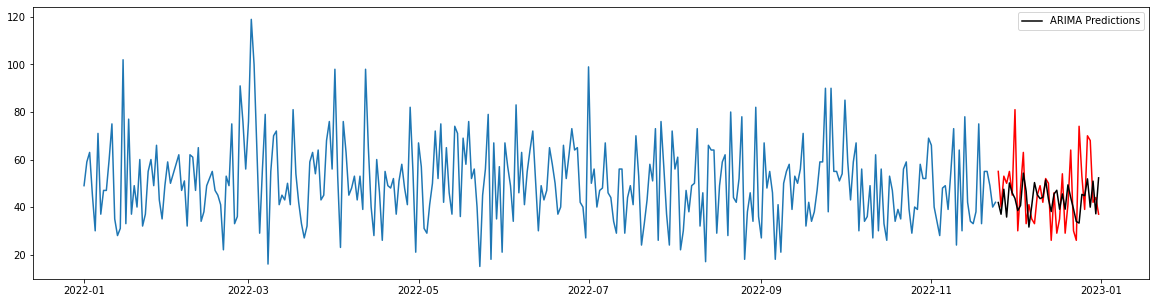

In [86]:
#ARIMA

df_train = df_train.set_index('Date')
df_test = df_test.set_index('Date')

y = df_train['Qty']

ARIMAmodel = ARIMA(y, order=(80, 2, 1))
ARIMAmodel = ARIMAmodel.fit()

y_pred = ARIMAmodel.get_forecast(len(df_test))

y_pred_df = y_pred.conf_int()
y_pred_df['predictions'] = ARIMAmodel.predict(start=y_pred_df.index[0], end=y_pred_df.index[-1])
y_pred_df.index = df_test.index
y_pred_out = y_pred_df['predictions']

eval(df_test['Qty'], y_pred_out)

plt.figure(figsize=(20, 5))
plt.plot(df_train['Qty'])
plt.plot(df_test['Qty'], color='red')
plt.plot(y_pred_out, color='black', label='ARIMA Predictions')
plt.legend()